# Hand gesture Recognition - commentary



> Na podstawie [tutorialu](https://gogul.dev/software/hand-gesture-recognition-p1)



# POJĘCIA

**Ekstrakcja** – wyodrębnianie składnika najbardziej się wyróżniającego.

**Bounding box** - minimalne wymiary pudełek, w których muszą się mieścić wszystkie elementy.

**ROI - bounding box** - prostokątny region zainteresowania (ROI) na obrazie w OpenCV.

**Wypukła otoczka (Convex Hull)** - wypukła otoczka zbioru punktów Q to najmniejszy wypukły wielokąt taki, że każdy punkt ze zbioru Q leży albo na brzegu wielokąta albo w jego wnętrzu.

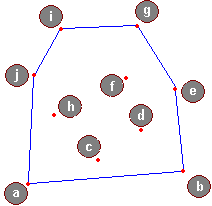

Jak widać otoczka składa się z 6 wierzchołków, jest to najmniejszy podzbiór zbioru Q taki że ich ciąg tworzy otoczkę zbioru Q.
Bardzo dobrze to opisano [tutaj](http://informatyka.wroc.pl/node/910).

**Średnia ruchoma, średnia krocząca (ang. running average)** – metoda statystyczna używana do analizy szeregów czasowych. Najprostsza to zwykła średnia arytmetyczna wartości z ostatnich n okresów. Jeśli przez p0 oznaczymy ostatnią wartość, to

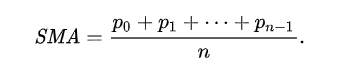

**Progowanie (ang. thresholding)** – metoda uzyskiwania obrazu binarnego na podstawie obrazu kolorowego lub w odcieniach szarości. Polega na wyznaczeniu dla danego obrazu progu jasności, a następnie piksele jaśniejsze od wyznaczonego progu otrzymują jedną wartość, a ciemniejsze drugą. Częstym zastosowaniem progowania jest oddzielenie obiektów pierwszoplanowych od tła.

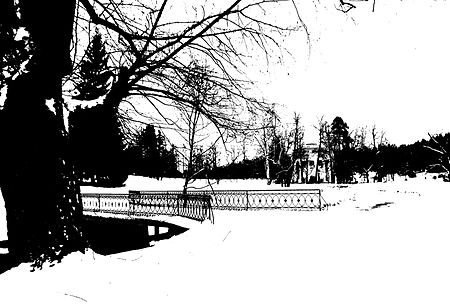

**Segmentacja obrazu (ang. image segmentation)** – proces podziału obrazu na części określane jako obszary (regiony), które są jednorodne (homogeniczne) pod względem pewnych wybranych własności. Obszarami są zbiory pikseli (punktów). Własnościami, które są często wybierane jako kryteria jednorodności obszarów są: poziom szarości, barwa, tekstura.

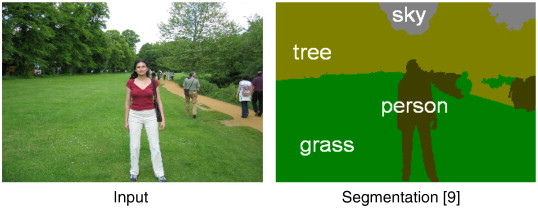

Rozpoznamy gesty dłoni z sekwencji wideo. Aby rozpoznać te gesty z sekwencji wideo na żywo, najpierw musimy wyjąć sam obszar dłoni, usuwając wszystkie niechciane fragmenty sekwencji wideo. Po podzieleniu obszaru dłoni liczymy palce pokazane w sekwencji wideo, aby poinstruować robota na podstawie liczby palców. W ten sposób cały problem można rozwiązać za pomocą 2 prostych kroków -


1.   Znajdź i podziel region ręki na podstawie sekwencji wideo.
2.   Policz liczbę palców z segmentowanego regionu dłoni w sekwencji wideo.

# CZĘŚĆ 1

**Sekwencja wideo** to tylko zbiór ramek lub zbiór obrazów, który działa względem czasu.

Potrzebujemy wydajnej metody oddzielenia pierwszego planu od tła. Aby to zrobić, używamy koncepcji **średnich średnich** (running averages). Sprawiamy, że nasz system przegląda określoną scenę na 30 klatek. W tym okresie obliczamy *running average* dla bieżącej i poprzednich klatek. W ten sposób zasadniczo mówimy naszemu systemowi, że:

>*Ok robot! Sekwencja wideo, na którą się gapiłeś (średnia z tych 30 klatek) jest tłem.*

Po ustaleniu tła, wsuwamy dłoń i uświadamiamy system, że nasza ręka jest nowym wejściem w tło, co oznacza, że staje się obiektem pierwszego planu. Ale w jaki sposób zamierzamy usunąć ten pierwszy plan sam? Odpowiedź brzmi: **odejmowanie tła** (Background Subtraction).

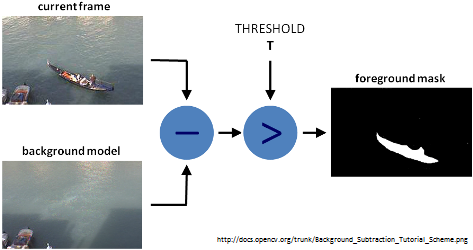

Po opracowaniu modelu tła za pomocą running averanges, oprócz tła używamy bieżącej ramki, która zawiera foreground object (w naszym przypadku dłoń). Obliczamy bezwzględną różnicę między modelem tła (aktualizowanym w czasie) a bieżącą ramką (która ma naszą rękę), aby uzyskać obraz różnicy, który przechowuje nowo dodany obiekt pierwszego planu (który jest naszą ręką). Na tym właśnie polega odejmowanie tła.

Po thresholdingu szukamy konturów w resulting image. Kontur z największym powierzchnią jest założony, że jest naszą ręką.

Zatem nasz pierwszy krok do znalezienia regionu ręki z sekwencji wideo obejmuje trzy proste kroki.

1. Odejmowanie tła (Background Subtraction)
2. Detekcja ruchu i progowanie (Motion Detection and Thresholding)
3. Ekstrakcja konturu (Contour Extraction)

In [0]:
import cv2
import imutils
import numpy as np

# zmienna globalna
bg = None

### 1. RUNNING AVERAGE

In [0]:
def running_average(image, aWeight):
  global bg

  if bg is None:
    bg = image.copy().astype("float")
    # kopiuje ramkę i zmienia na typ zmiennoprzecinkowy
    return

    # cv2.accumulateWeighted(src, dst, mask)
    # liczy śreednią ważoną, gromadzi ją i aktualizuje tło
    # source (src) - input image jako 1 lub 3-kanał,
    # 8-bit albo 32-bit zmiennprzecinkowa
    # destination (dst) - obraz akumulatora z taką samą liczbą
    # kanałów jak obraz wejściowy, 32-bit lub 64-bit zmiennoprzecinkowy
    # mask - opcjonalna maska operacji

    cv2.accumulateWeighted(image, bg, aWeight)

Następnie mamy naszą funkcję, która służy do obliczenia running average między modelem tła i bieżącą ramką. Ta funkcja przyjmuje dwa argumenty - bieżącą frame i aWeight, która jest jak próg pozwalający na obliczenie running average dla obrazów. Jeśli model tła to None (tj. Jeśli jest to pierwsza ramka), zainicjuj go z bieżącą ramką.

Następnie oblicz średnią bieżącą dla modelu tła i bieżącej ramki za pomocą funkcji cv2.accumulateWeighted(). Średnia ruchoma jest obliczana przy użyciu poniższego wzoru:

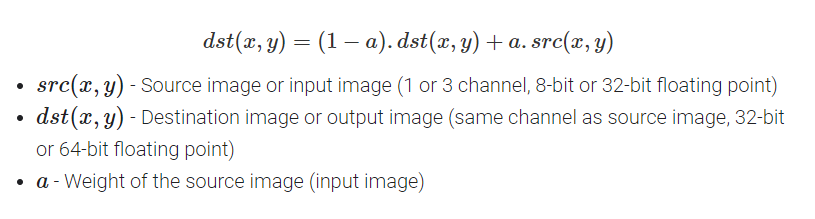

***(patrz: komentarz w kodzie wyżej)***

In [0]:
def segmentacja(image, prog=25):
  global bg
  # znajdź abs z różnicy między tłem i bieżącą ramką
  diff = cv2.absdiff(bg.astype("uint8"), image)
  # uint8 - [0, 255]

  # progowanie diff obrazu, aby zdobyć foreground
  progowany = cv2.threshold(diff, prog, 255, cv2.THRESH_BINARY)[1]
  # cv2.threshold(img, thr, max, type)
  # używany do progowania (ten biało-czarny rysunek na górze)
  # img - obraz źródłowy, który powinien być grayscale
  # thr - wartość progowa, która służy do klasyfikacji wartości pikseli
  # czyli jeśli mniejszy, to daj mu 0, jeśli większy, daj 1
  # max - największa wartośc przypisana pixelom wykraczającym poza skalę
  # type - typ progowania, tutaj binarka - albo 0 albo 1 (albo min albo max)

  # złap kontury w progowanym obrazie
  kontury, hierarchia = cv2.findContours(progowany.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)
  # cv2.findContours(img, cnts, hier)
  # img - obraz źródłowy
  # cnts - tryb pobierania konturu
  # hier - hierarchia

  # zwróć None, jeśli nie wykryło konturu
  if len(kontury) == 0:
    return
  else:
    # wzorując się na contour area, zwróć największy kontur, który jest ręką
    wydzielony = max(kontury, key=cv2.contourArea)
    # key - funkcja klucza, w której iteratory są
    # przekazywane i porównywane jest na podstawie wartości zwracanej

    return (wyprogowany, wydzielony)


**CV_RETR_EXTERNAL** daje kontury „zewnętrzne”, więc jeśli masz jeden kontur obejmujący inny (jak koncentryczne okręgi), podana jest tylko najbardziej zewnętrzna.

**CHAIN_APPROX_SIMPLE** zwraca tylko punkty końcowe, które są niezbędne do narysowania linii konturowej

---------------------
Nasza następna funkcja służy do segmentowania regionu ręki z sekwencji wideo. Ta funkcja przyjmuje dwa parametry - bieżącą ramkę i próg używany do progowania difference image.



Po pierwsze, znajdujemy bezwzględną różnicę (absolute difference) między modelem tła a bieżącą ramką za pomocą funkcji cv2.absdiff().

Następnie progujemy obraz różnicy, aby odsłonić tylko obszar ręki. Na koniec wykonujemy ekstrakcję konturu na obrazie progowym i wykonujemy kontur z największym obszarem (który jest naszą ręką).



Zwracamy obraz progowy, a także obraz segmentowy jako krotkę. Matematyka tworzenia progów jest dość prosta. Jeśli x (n) reprezentuje intensywność pikseli obrazu wejściowego przy określonej współrzędnej pikseli, wówczas próg decyduje o tym, jak ładnie będziemy segmentować / progować obraz do obrazu binarnego.

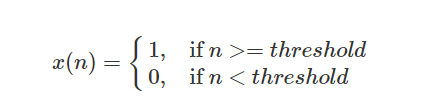

In [0]:
# --------------
# FUNKCJA GŁÓWNA
# --------------

if __name__ == "__main__":
  # inicjalizacja wagi dla running average
  aWeight = 0.5

  # nawiązanie z kamerą
  kamera = cv2.VideoCapture(0)

  # region, w który będziemy wkładać łapę jako koordynaty
  top, left, bottom, right = 40, 250, 255, 590

  # inicjalizacja ilosci ramek
  num_frames = 0

  while True:
    grabbed, frame = kamera.read()

    frame = imutils.resize(frame, width=700)

    # odbij zresize'owany obraz, żeby nie był mirror viewem
    frame = cv2.flip(frame, 1)

    frame_clone = frame.copy()

    height, width = frame.shape[:2] # utnij dwa ostatnie elementy

    wycinek = frame[top:bottom, right:left]

    # wycinek do grayscale i rozmycie
    gray = cv2.cvtColor(wycinek, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    #cv2.GaussianBlur(img, (wj, hj), sig)
    # img - źródłowy obraz
    # wj - kernel's width, szerokość jądra Gaussiana
    # hj - kernel's height, wysokość jądra Gaussiana
    # wj I hj MUSZĄ BYĆ LICZBAMI POZYTYWNYMI PIERWSZYMI
    # sig - standardowe odchylenie w x i y kierunkach

    # aby get the backgroung, szukaj, póki nie będzie progu (thresholda)
    # aby nasz model średniej bieżącej zostaje skalibrowany (ustalenie wartości)

    if num_frames < 30:
      running_average(gray, aWeight)
    else:
      # wytnij rękę
      hand = segment(gray)

      # sprawdź czy region ręki istnieje
      if hand is not None:
        # jeśli tak, wypakuj progowany obraz i wycięty region
        progowany, wycinek = hand

        # rysuj wycięty region i pokaż frame
        cv2.drawContours(frame_clone, [wycinek + (right + top)], -1, (0, 0, 25))
        # cv2.drawContours(,img, cntrs, cntrs_id, color)
        # img      - destination image
        # cntrs    - kontury jako vectory
        # cntrs_id - parametr wskazujący na kontur do narysowania. Jeśli jest
        # negatywny, to kontur jest rysowany
        # color - RGB

        # ---------------------------------
        # DODANE DOPIERO PO DRUGIEJ FUNKCJI
        # ---------------------------------
        #policz ilość palców
        palce = licz(progowany, wycinek)

        #narysuj tekst
        cv2.putText(frame_clone, str(palce), (70, 45), cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0, 0, 255), 2)
        # ---------------------------------

        cv2.imshow("Progowany", progowany)
    
    # rysuj wycinek ręki
    cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)
    # cv2.rectangle(img, start_pt, end_pt, color, thickness)

    # powiększ liczbę frames
    num_frames += 1

    # pokaż frame z wyciętą ręką
    cv2.imshow("Ręka", frame_clone)

    if cv2.waitKey(20) & 0xFF == ord("q"):
      break

  # zwolnij pamięć
  kamera.release()
  cv2.destroyAllWindows()
        

Inicjujemy wagę (*aWeight*) do 0,5. Jak pokazano wcześniej w równaniu średniej bieżącej, ten próg oznacza, że jeśli ustawisz niższą wartość dla tej zmiennej, średnia bieżąca zostanie wykonana na większej liczbie poprzednich ramek i odwrotnie. 

**Zamiast rozpoznawać gesty z ogólnej sekwencji wideo, spróbujemy zminimalizować strefę rozpoznawania (lub obszar), w której system musi szukać regionu dłoni.** Aby podświetlić ten region, używamy funkcji *cv2.rectangle()*, która wymaga współrzędnych górnego, prawego, dolnego i lewego piksela.

Aby śledzić liczbę klatek, inicjalizujemy zmienną *num_frames*. Następnie uruchamiamy nieskończoną pętlę i odczytujemy ramkę z naszej kamery internetowej za pomocą funkcji *kamera.read()*. Następnie zmieniamy rozmiar ramki wejściowej na stałą szerokość *700* pikseli przy zachowaniu współczynnika kształtu za pomocą biblioteki *imutils* i odwracamy ramkę, aby uniknąć odbicia lustrzanego.

Następnie usuwamy tylko region zainteresowania (tj. strefę rozpoznawania -  recognizing zone), używając prostego krojenia NumPy. Następnie przekształcamy ten ROI w obraz w skali szarości i używamy rozmycia gaussowskiego, aby zminimalizować składowe wysokiej częstotliwości na obrazie (*high frequency components in the image*). **Aż do przekroczenia 30 ramek dodajemy ramkę wejściową do naszej funkcji running_avgerage i aktualizujemy nasz model tła. Należy pamiętać, że na tym etapie obowiązkowe jest trzymanie aparatu (kamery) bez ruchu. W przeciwnym razie cały algorytm zawiedzie.**

Po zaktualizowaniu modelu tła bieżąca ramka wejściowa jest przekazywana do funkcji *wycinek()*, a obraz progowy (*progowany*) i *wycinek* są zwracane. Segmentowany (wycięty) kontur jest rysowany nad ramką za pomocą *cv2.drawContours()*, a wyjście progowe jest wyświetlane za pomocą *cv2.imshow()*.

Na koniec wyświetlamy segmentowany (wycięty) obszar dłoni w bieżącej ramce i czekamy na naciśnięcie klawisza, aby wyjść z programu. Zauważ, że utrzymujemy tutaj zmienną *bg* jako zmienną globalną. Jest to ważne i należy się tym zająć.

# 2. CZĘŚĆ 2

**Otrzymaliśmy segmentowany obszar dłoni, zakładając, że jest on największym konturem (tj. Konturem z maksymalnym obszarem) w ramce**. Jeśli wprowadzisz do tej ramki jakiś duży obiekt, który jest większy niż twoja ręka, algorytm zawodzi. Musisz więc upewnić się, że twoja ręka zajmuje większość regionu w kadrze.

Użyjemy segmentowanego (wyciętego) regionu ręki, który został uzyskany w zmiennej *hand*. Pamiętaj, że ta zmienna *hand* jest krotką posiadającą *progowany* (obraz progowy) i *wycinek* na segmenty (region ręki podzielony na segmenty). Wykorzystamy te dwie zmienne do zliczenia pokazanych palców.

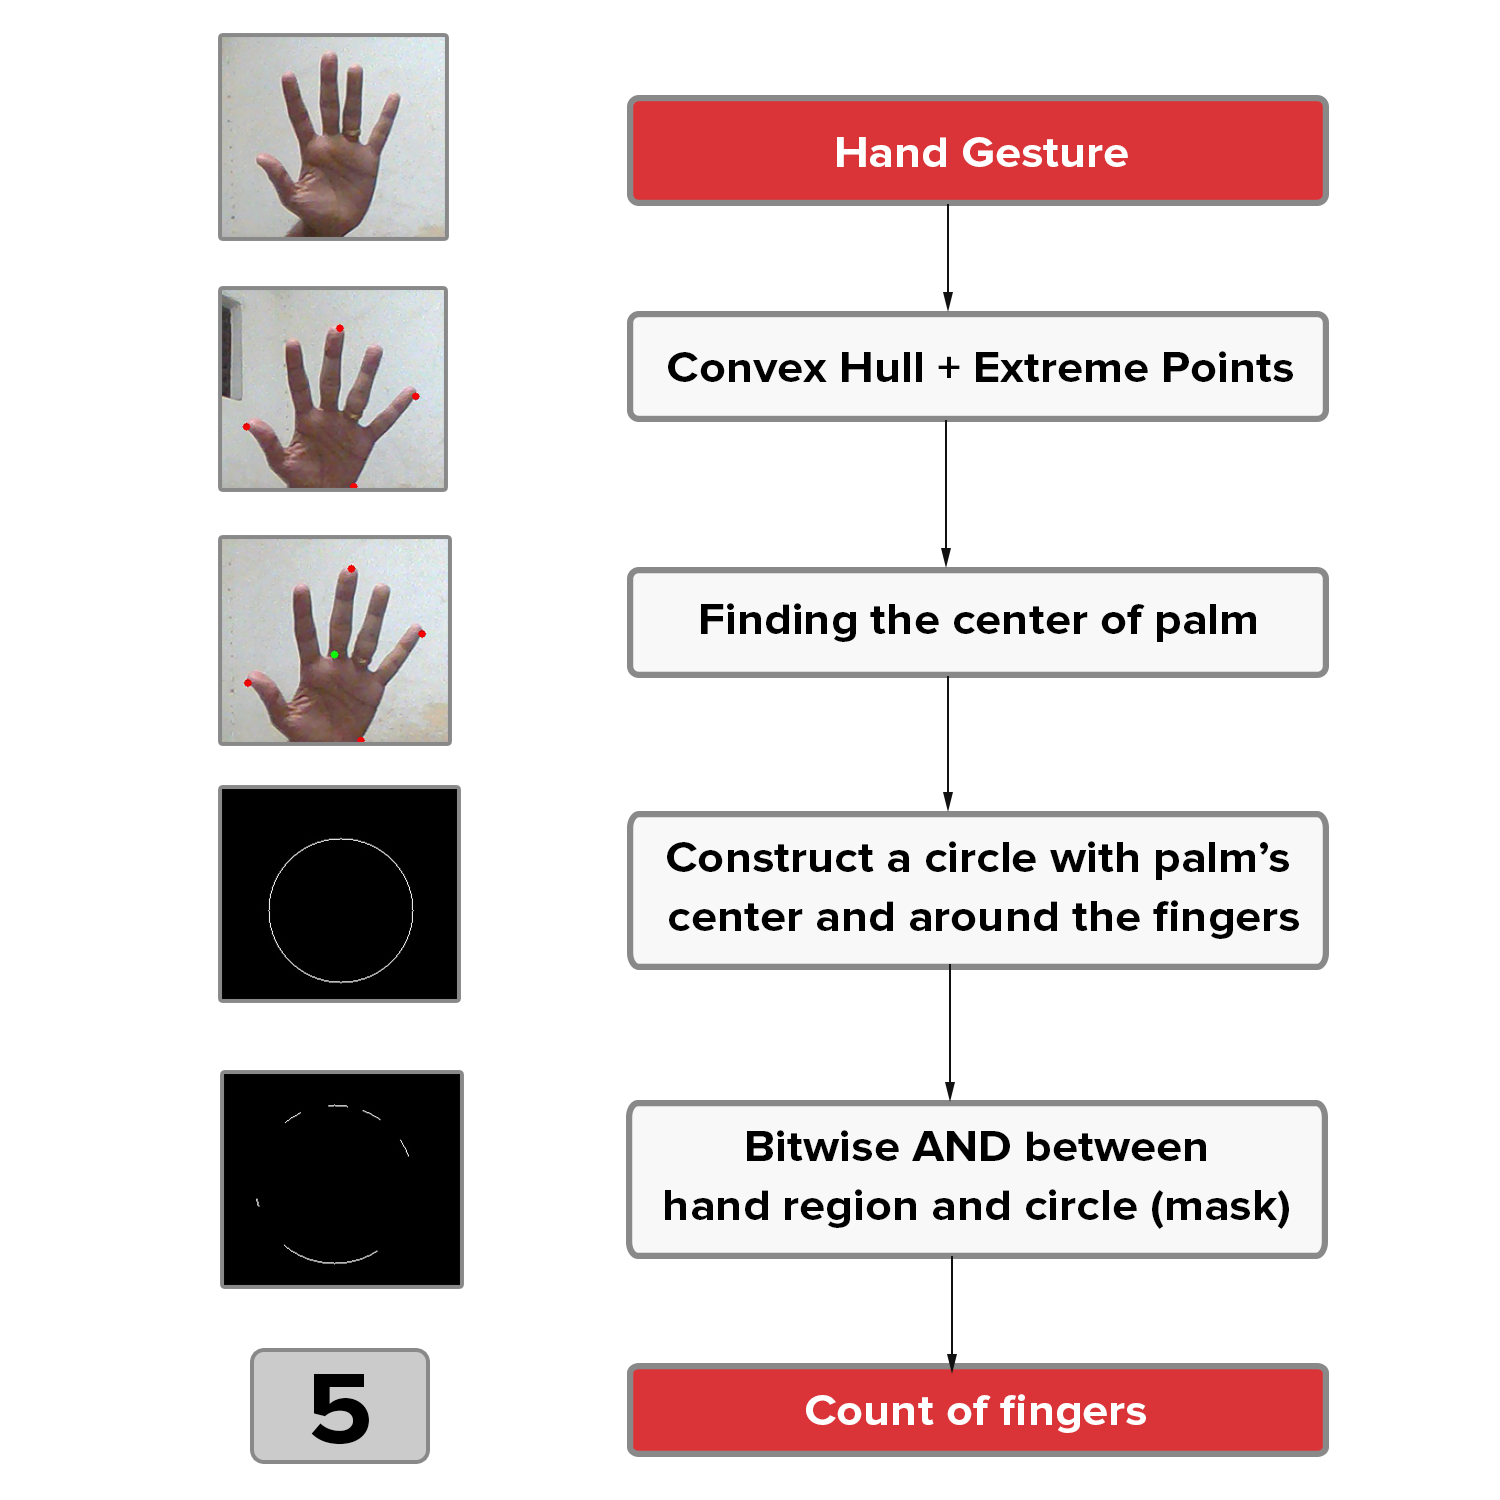

1. Znajdź wypukłą otoczkę (**Convex Hull**) segmentowanego (wyciętego) obszaru dłoni (który jest konturem) i oblicz najbardziej ekstremalne punkty w wypukłym kadłubie (Extreme Top, Extreme Bottom, Extreme Left, Extreme Right).
2. Znajdź środek dłoni używając tych ekstremów w **Convex Hull**.
3. Używajac środka dłoni, skonstruuj koło z maksymalnym odległością euklidesową (maximum Euclidean distance) [pomiędzy centrum dłoni i punktami ekstremum] jako promień.
4. Operacja bitwise AND pomiędzy progowanym obrazem dłoni i cyrkularnym ROI (maską). Ujawni to odcięcia między pacami, które można wykorzystać do obliczenia liczby pokazanych palców.

## FUNKCJA:
**input**   - progowany (progowany obraz) i wycinek (segmentowany obszar dłoni albo kontur)
**output**  - numer palców

In [0]:
#----------------------------------------
# wyliczenie ilości palców w wycinku ręki
#----------------------------------------
from sklearn.metrics import pairwise
import cv2

def licz(progowany, wycinek):
  # znajdź odetek wycinka dłoni
  chull = cv2.convexHull(wycinek)

  # znajdz ekstrema w odsetku
  ex_top     = tuple(chull[chull[:, :, 1].argmin()][0])
  ex_bottom  = tuple(chull[chull[:, :, 1].argmax()][0])
  ex_left    = tuple(chull[chull[:, :, 0].argmin()][0])
  ex_right   = tuple(chull[chull[:, :, 0].argmax()][0])

  # znajdź centrum dłoni
  center_x = int((ex_left[0] + ex_right[0]) / 2)
  center_y = int((ex_top[1] + ex_bottom[1]) / 2)

  # maksymalna odległość euklidesowa między centrum dłoni a najbardziej
  # ekstremalnymi punktami convex hullu ("otoczką")
  odleglosc = pairwise.euclidean_distances([(center_x, center_y)],
                        Y=[ex_left, ex_right, ex_top, ex_bottom])[0]
  # pairwise.euclidean_distance(x, y)
  # zarówno X jak i Y są matrycami
  # Biorąc pod uwagę rzędy X (i Y = X) jako wektory,
  # oblicz macierz odległości między każdą parą wektorów.
  # Ze względu na wydajność odległość euklidesowa między parą wektora
  # rzędu x i y oblicza się jako:
  # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
  max_odleglosc = odleglosc[odleglosc.argmax()]

  # wylicz promień koła z 80% maksymalnej uzyskanej odległości euklidesowej
  promien = int(0.8 * max_odleglosc)

  # znajdź obwód koła:
  obwod = 2 * np.pi * promien

  # wytnij okrągły obszar zainteresowania, który ma dłoń i palce
  okragle_ROI = np.zeros(thresholded,shape[:2], dtype="uint8")

  # narysuj okrągłe ROI
  cv2.circle(okragle_ROI, (center_x, center_y), promien, 255, 1)
  # pierwszy argument to obraz na którym ma być rysowane

  # policz AND z progowanej dłoni używając okrągłego ROI jako maski,
  # co daje wycinki uzyskane z progowanego obrazu dłoni
  okragle_ROI = cv2.bitwise_and(progowany, progowany, mask=okragle_ROI)

  # policz kontury w okrągłym ROI
  kontury, _ = cv2.findContours(okragle_ROI.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_NONE)
  
  # liczydło do palców
  count = 0

  # iteracja w odnalezionych konturach
  for kontur in kontury:
    # obliczenie wymiaróow pudełka (bounding box) na kontury
    x, y, w, h = cv2.boundingRect(c)
    # cv2.boundingRect()
    # służy do rysowania przybliżonego prostokąta wokół obrazu binarnego.
    # Ta funkcja jest używana głównie do podświetlania obszaru
    # zainteresowania po uzyskaniu konturów z obrazu.

    # powiększ liczydło do palców, jeśli:
    # 1. kontur nie jest nadgarstkiem (dolny region)
    # 2. numer punktów wzdłuż konturu nie przekracza 25% obwodu okrągłego ROI
    if ((center_y + (center_y * 0.25)) > (y + h)) and ((obwod * 0.25) > c.shape[0]):
      count += 1
  
  return count

